In [1]:
%matplotlib inline
%load_ext memory_profiler

import os, sys, glob, re, math, pickle
import phate,scprep,magic,meld
import graphtools as gt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time,random,datetime
from sklearn import metrics
from sklearn import model_selection
from scipy import sparse
from scipy.stats import mannwhitneyu, tiecorrect, rankdata
from statsmodels.stats.multitest import multipletests
import scanpy as sc
import scvelo as scv
from adjustText import adjust_text
import warnings
from matplotlib import gridspec



# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1
sns.set_style("ticks")

In [2]:
# fps
dfp = '/home/cl2292/project/SCA1_snRNAseq/Human/data/'
pfp = '/home/cl2292/project/SCA1_snRNAseq/Human/results_20230402/'
pdfp = '/home/cl2292/project/SCA1_snRNAseq/Human/data/processed/'
sc.settings.figdir = pfp

In [3]:
# settings
plt.rc('font', size = 8)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=8)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1



In [4]:
# Load Data

if True :
    start = time.time()
    backed=None # None if not
    fname='230502_human_ctype.h5ad' # for full, can maybe get away with ~300G
    %memit adata = sc.read_h5ad(os.path.join(pdfp,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))

peak memory: 11500.79 MiB, increment: 11303.72 MiB
loaded @230512.11:46:10
took 15.52-s to load data


In [5]:
##Original - use for UMAP

cmap_sub4={'GC': '#FAC18A',
            'UBC': '#BA61BA',
            'PC': '#EE5264',
            'MLI1': '#F9EBAE',
            'MLI2': '#88BB92',
            'GoC': '#46A928',
            'AS': '#F9AEAE',
            'BG': '#AEB7F9',
            'OPC': '#F1815F',
            'OL': '#75A3B7',
            'MG': '#AC5861',
            'PER': '#2D284B',
            'END': '#1C67EE'}

adata.uns['sub4_colors']=np.array(list(cmap_sub4.values()),dtype=object)
adata.obs['sub4'].cat.reorder_categories(new_categories=list(cmap_sub4.keys()),
                                         inplace=True,ordered=True)

In [6]:
order_human=[
    'GC',
    'UBC',
    'PC',
    'MLI1',
    'MLI2',
    'GoC',
    'AS',
    'BG',
    'OPC',
    'OL',
    'MG',
    'PER',
    'END'
]

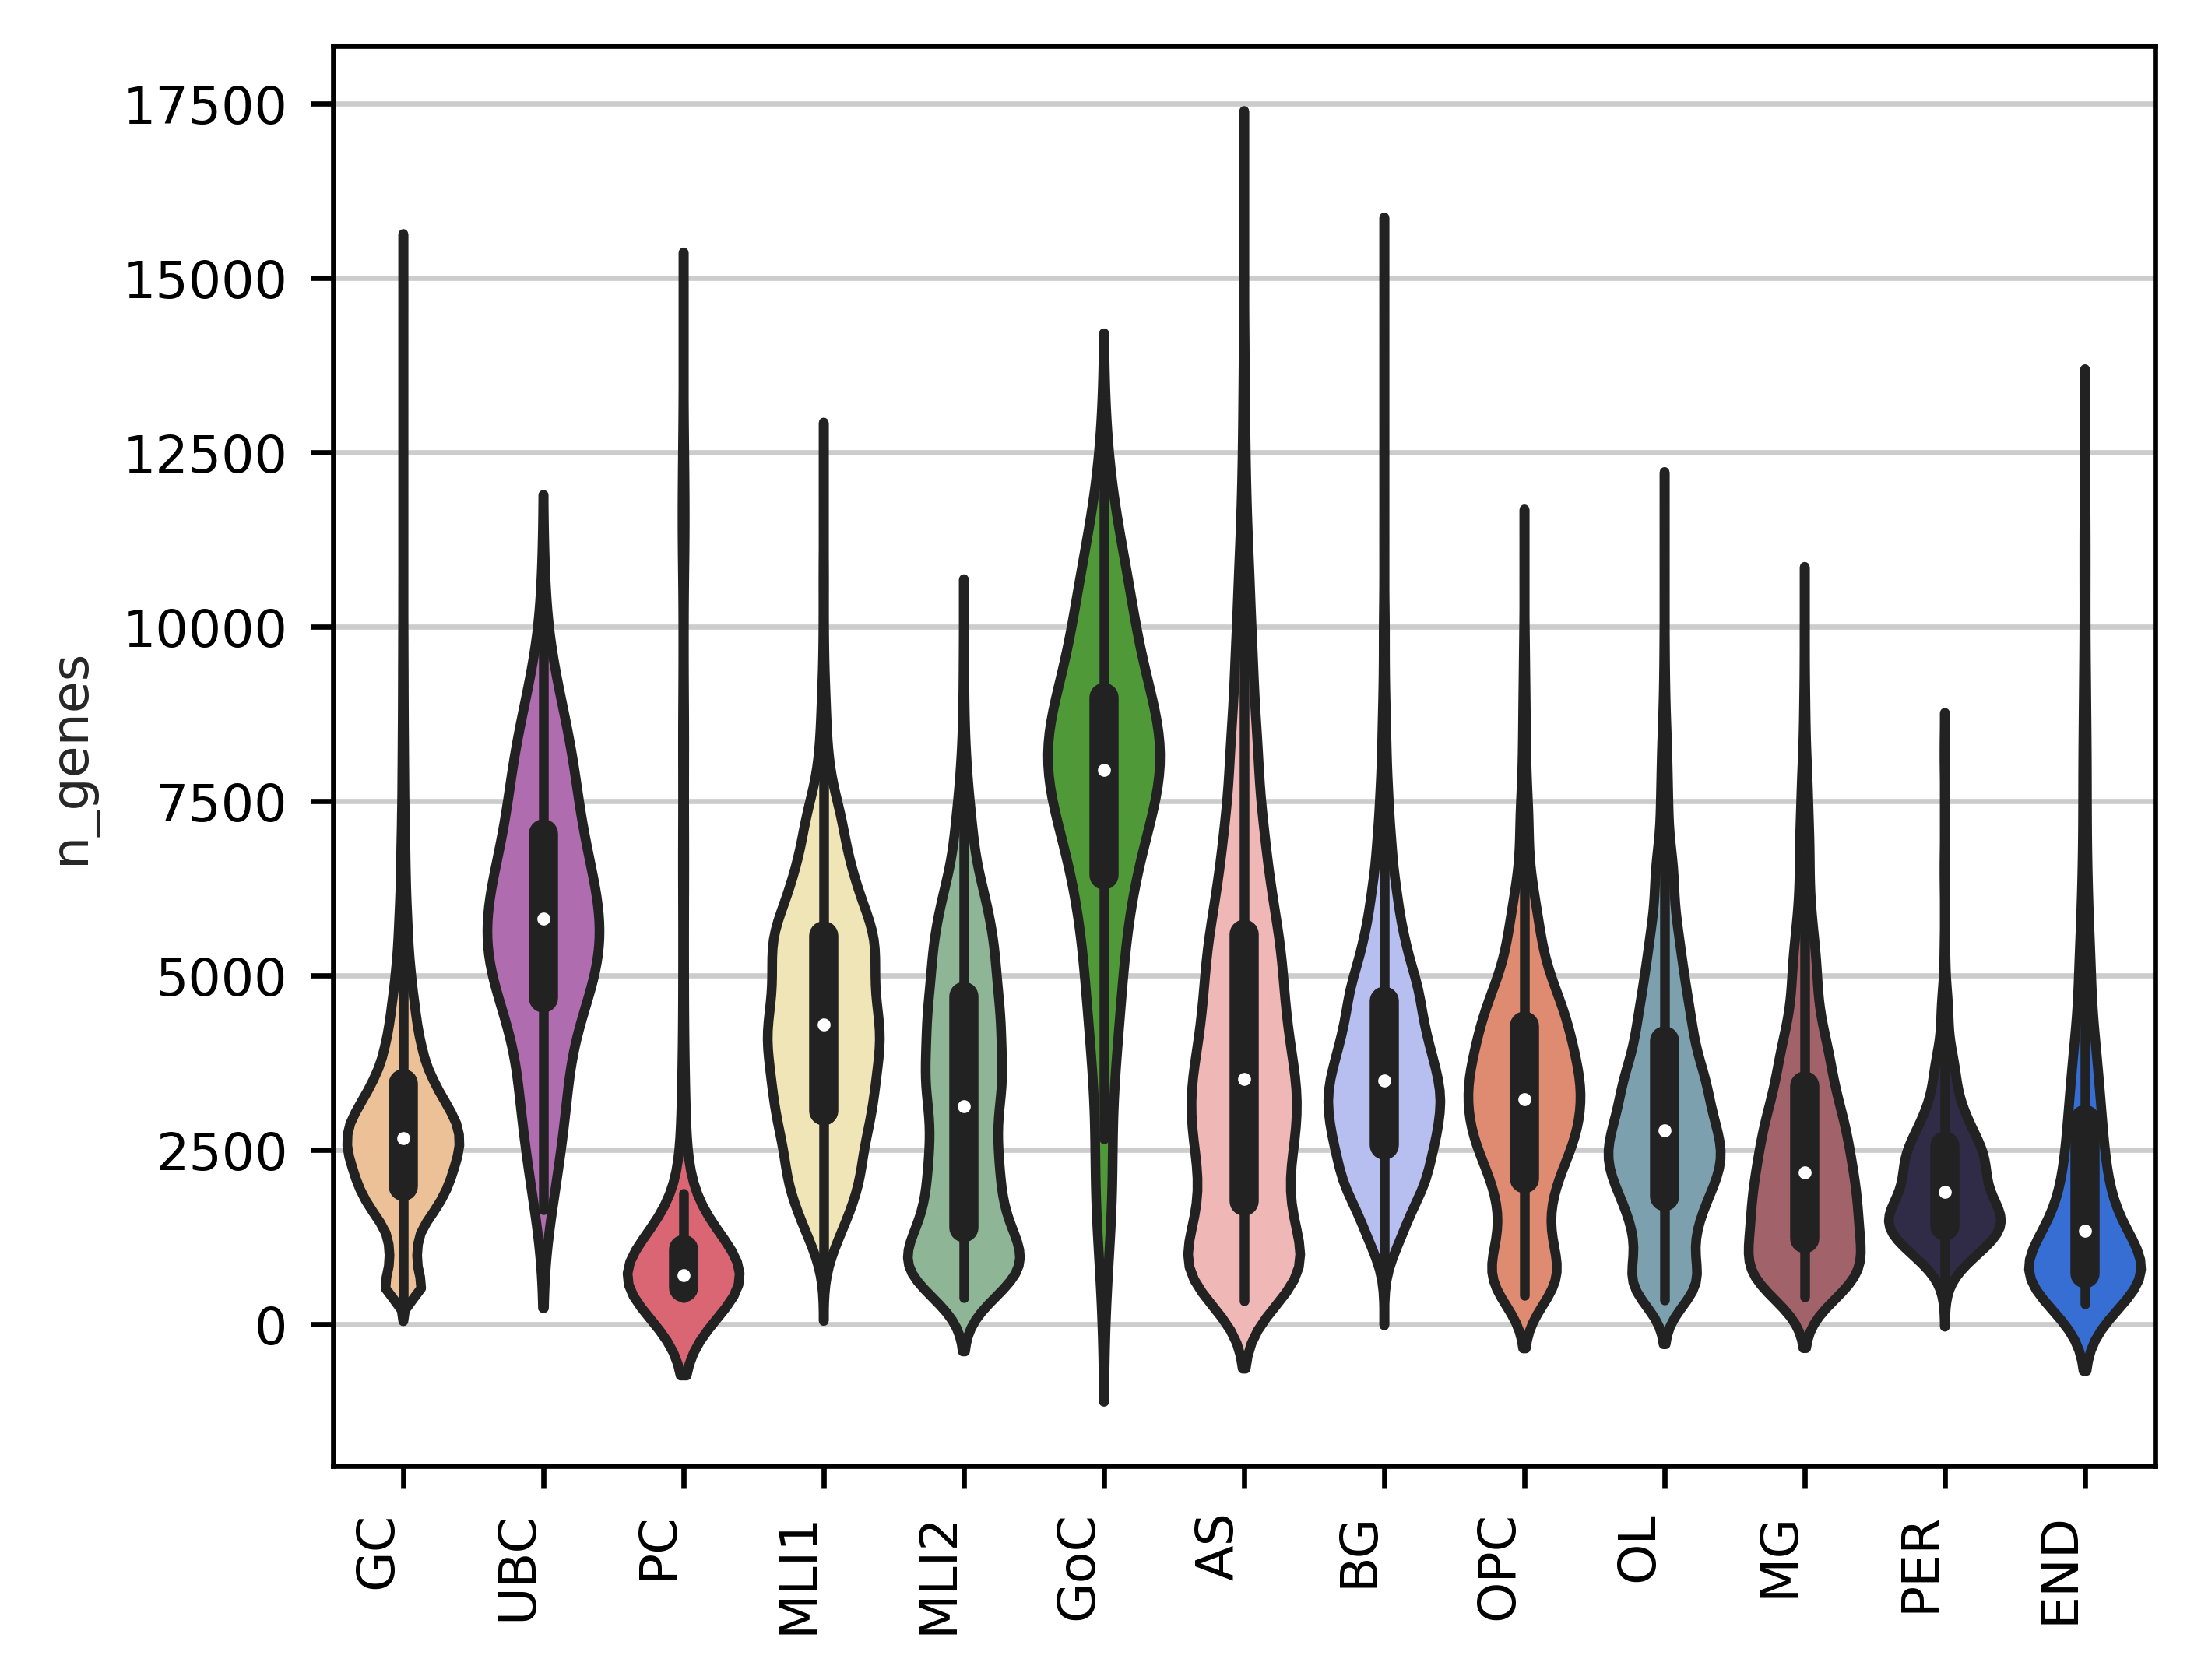

In [7]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.violinplot(x='sub4', y='n_genes', data=adata.obs, dodge=False, ax=ax, hue='sub4', palette=cmap_sub4,
              order=order_human)
# ax.set_yscale('log')
ax.legend().set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
ax.set_xlabel('')
fig.savefig(os.path.join(pfp, 'n_genes_human_by_ctype.pdf'))

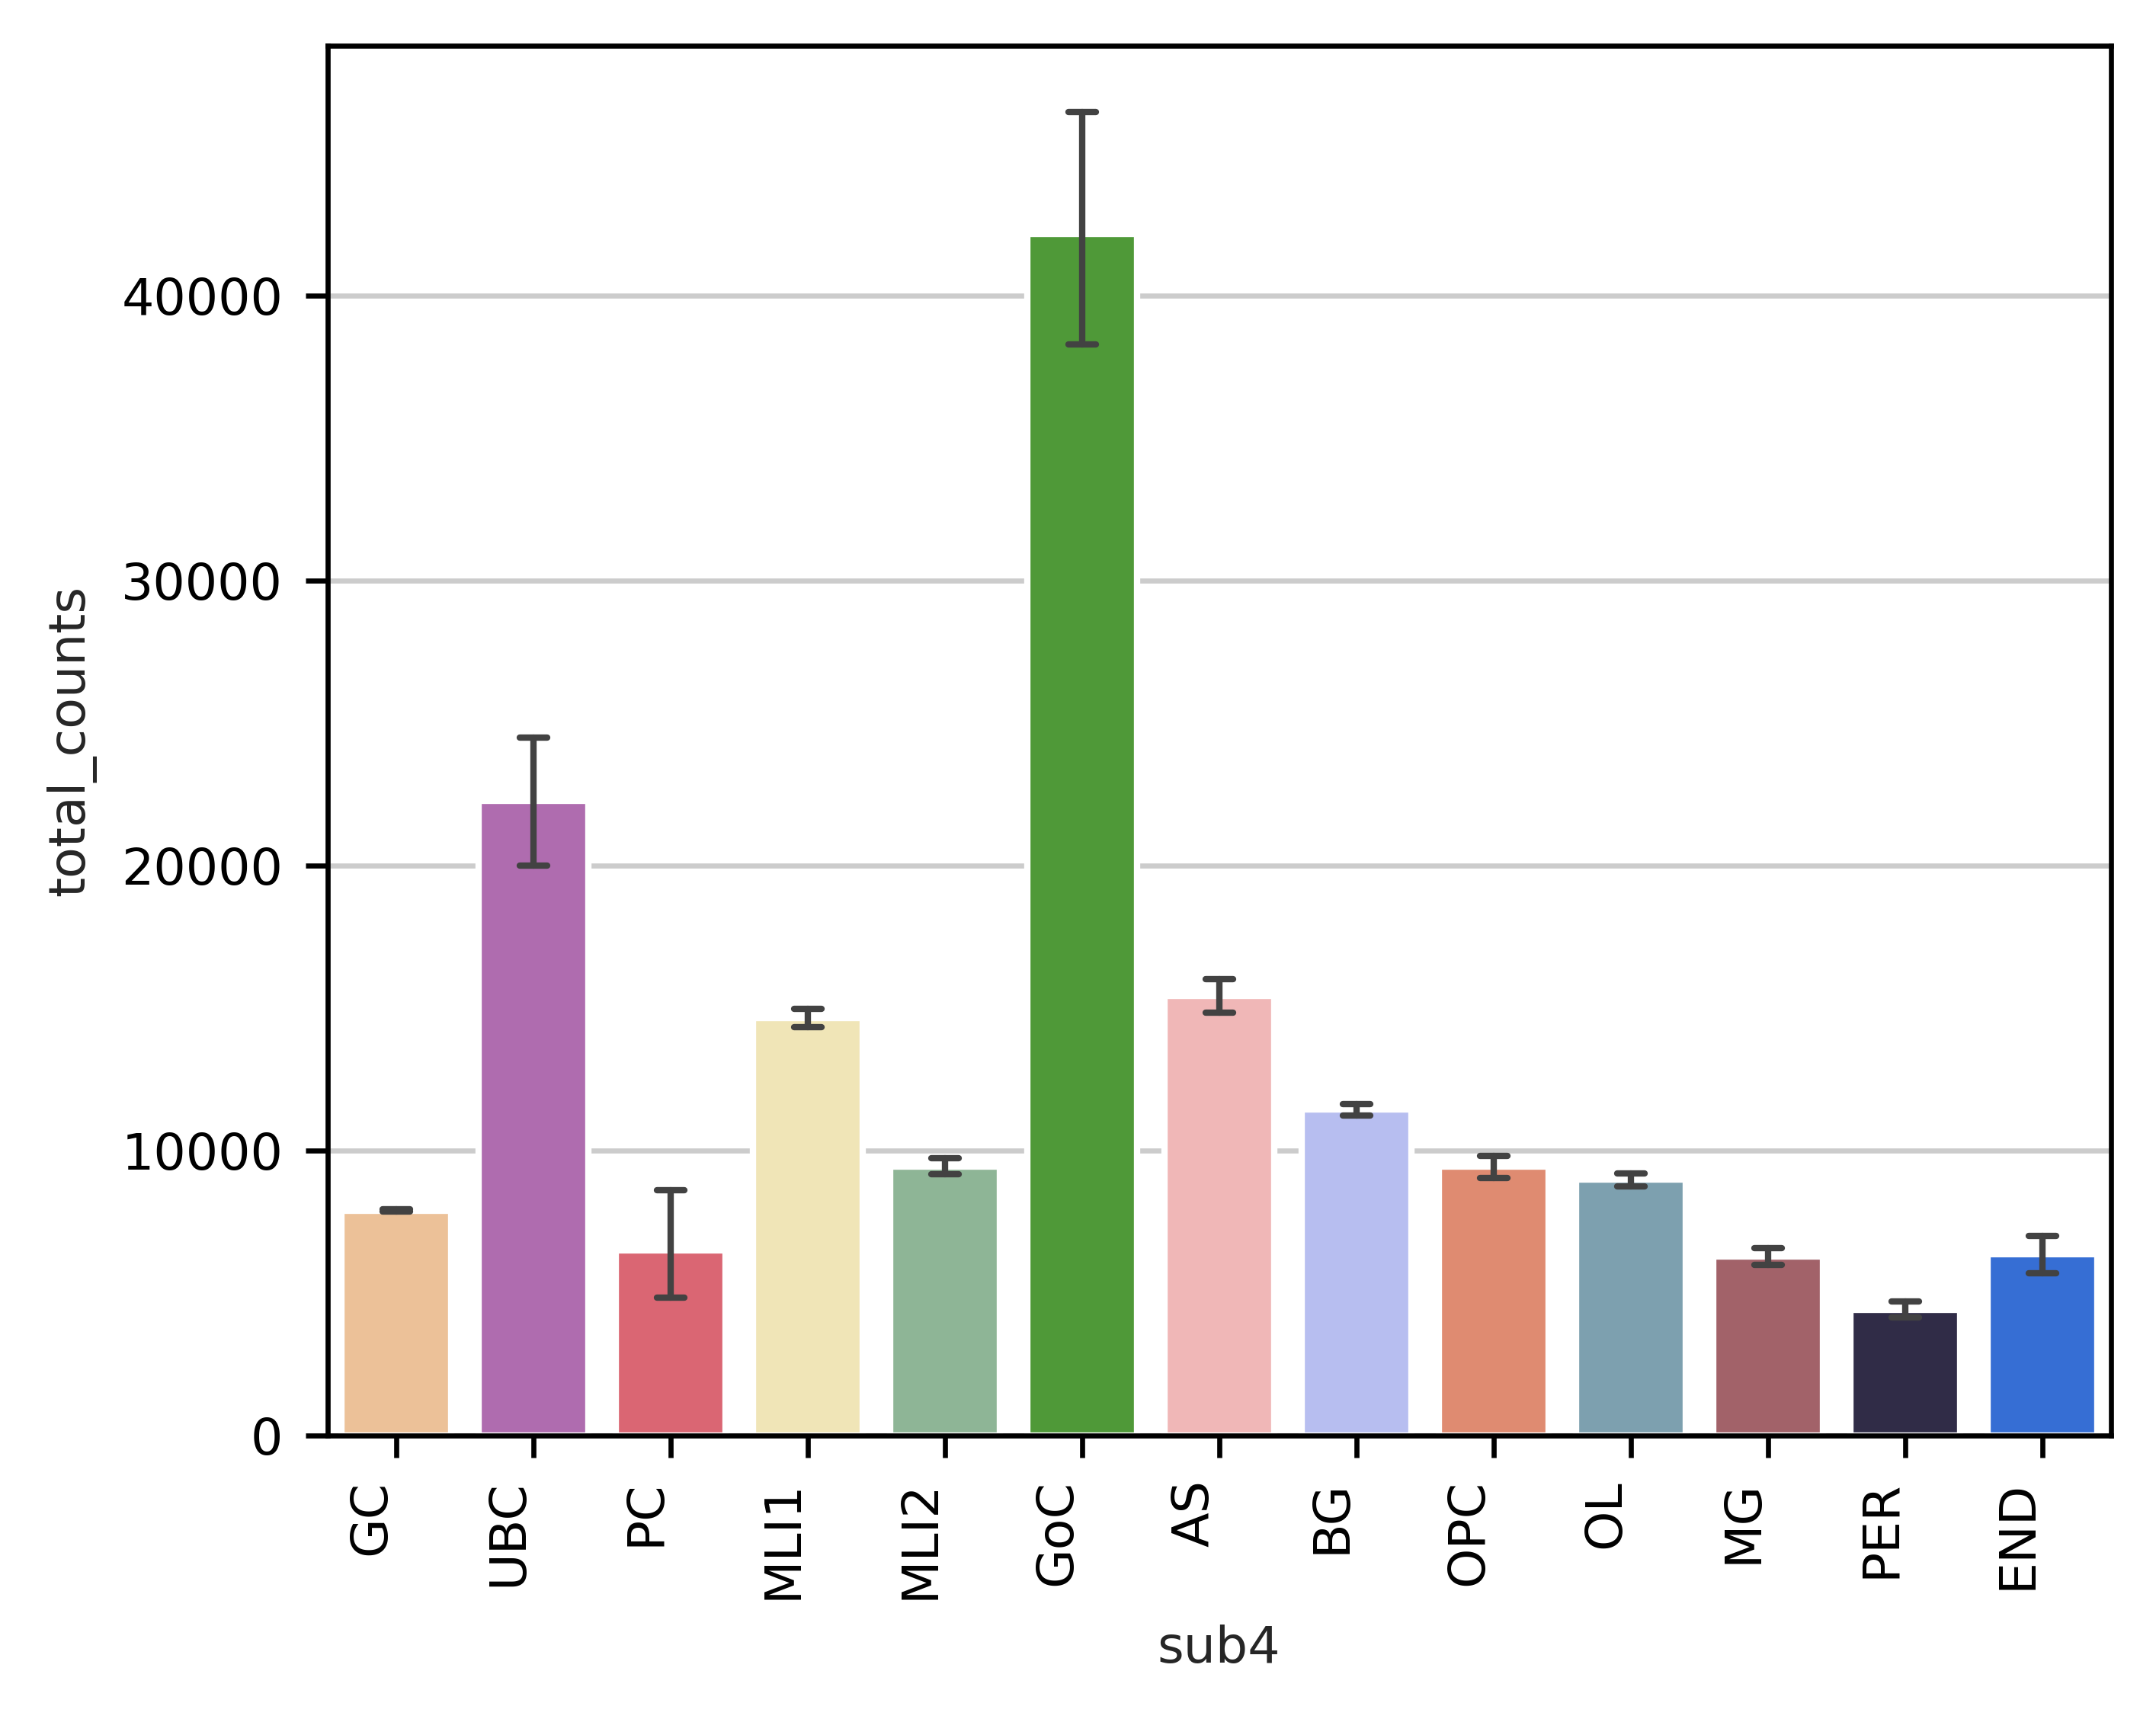

In [9]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

sns.barplot(x='sub4', 
               y='total_counts', 
               data=adata.obs, 
               dodge=False, 
               ax=ax, 
               hue='sub4', 
               palette=cmap_sub4,
               capsize=.2,
#               linewdith=0.1,
               errwidth=1,
               order=order_human)

# ax.set_ylim([0, 50000])
# ax.set_yscale('log')
ax.legend().set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

fig.savefig(os.path.join(pfp, 'umi_count_hum_by_ctype.pdf'))

In [14]:
##color map for UMAP for batch
#Ctrl = ['14', '409', '4092', '1516', '15162', '729', '1432', '1532', 'T136', 'T1952', 'T551', 'T99']
#SCA1 = ['11', '12', '13', '122', '132', 'CB', 'CT', 'RT', 'CNGA-0047', 'CNGA-0061', 'CNGA-0064', 'UMB1354']

cmap_batch={'14': '#9A6324',
            '409': '#808000',
            '4092':'#808000',
            '1516':'#BFEF45',
            '15162':'#BFEF45',
            '729':'#3CB44B',
            '1432':'#AAFFC3',
            '1532':'#42D4F4',
            'T136':'#4363D8',
            'T1952':'#469990',
            'T551':'#000075',
            'T99':'#000000',
            '11':'#800000',
            '12':'#E6194B',
            '122':'#E6194B',
            '13':'#FABED4',
            '132':'#FABED4',
            'CB':'#F58231',
            'CT':'#FAAD52',
            'RT':'#FFD8B1',
            'CNGA-0047':'#FFE119',
            'CNGA-0061':'#FFFAC8',
            'CNGA-0064':'#911EB4',
            'UMB1354':'#F032E6'}

adata.uns['batch_colors']=np.array(list(cmap_batch.values()),dtype=object)
adata.obs['batch'].cat.reorder_categories(new_categories=list(cmap_batch.keys()),
                                         inplace=True,ordered=True)

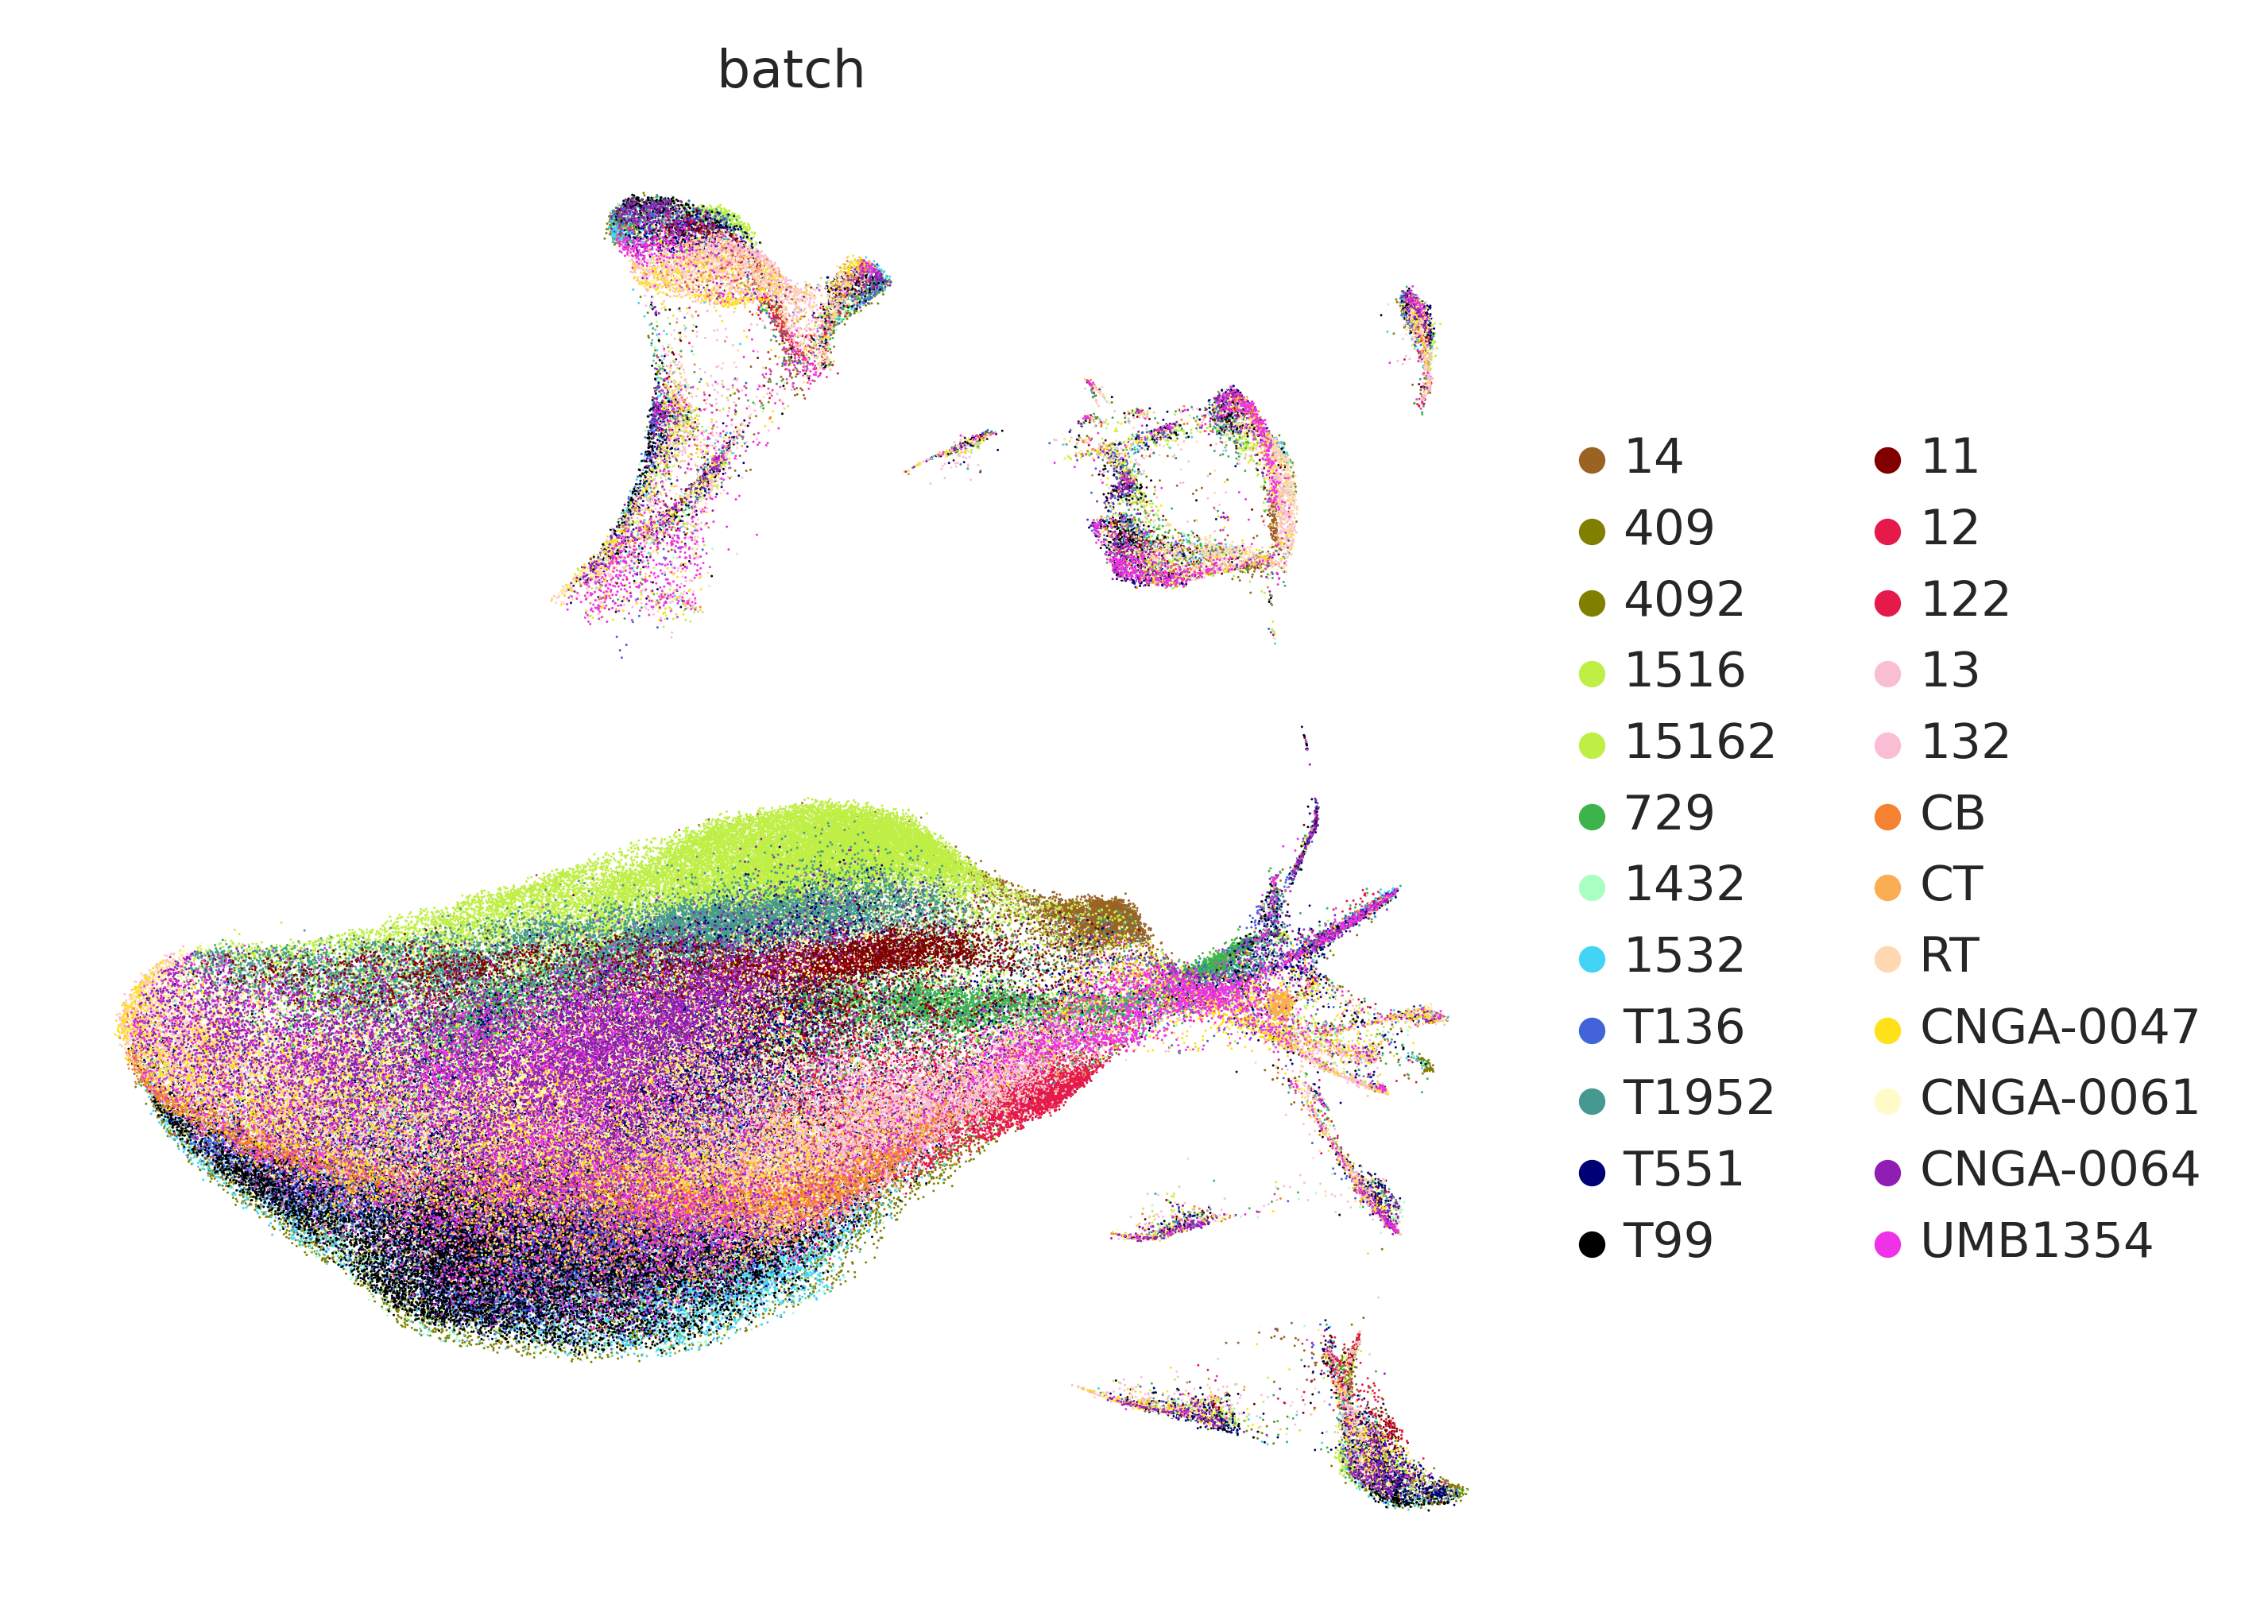

In [15]:
sc.pl.umap(adata, color = 'batch',
           save = '230512_human_umap_batch.pdf'
          )